# Extract features

In [1]:
text_html_map = {
    r'\n': r' ',
    r'&gt;': r'>',
    r'&lt;': r'<',
    r'&amp;': r'&',
    r'&quot;': r'"',
    r'&ndash;': r'–',
    r'##### ': r'',
    r'\\\\\\\\': r'\\',
    r'  ': r' ',
    r'——': r'-',
    r'—': r'-',
    r'/': r'',
    r'\^': r'',
    r'^': r'',
    r'±': r'+'
}

def read_edus(filename):
    edus = []
    with open(filename + '.edus', 'r') as f:
        for line in f.readlines():
            edu = str(line.strip())
            for key, value in text_html_map.items():
                edu = edu.replace(key, value)
            edus.append(edu)
    return edus

def read_annotation(filename):
    annot = pd.read_pickle(filename + '.nlp')
    for key, value in text_html_map.items():
        annot['text'] = annot['text'].replace(key, value)
    return annot

In [2]:
from glob import glob
import pandas as pd


def extract_triplets(edus, annot):
    triplets = []
    cursor = 0
    
    for sentence in range(len(annot['sentences'])):
        for token in range(annot['sentences'][sentence].begin, annot['sentences'][sentence].end):
            if token == annot['sentences'][sentence].begin:
                if token > 0:
                    left_neighbour = (#annot['tokens'][token-1].text,
                                      annot['lemma'][sentence-1][-1],
                                      annot['postag'][sentence-1][-1],
                                      annot['syntax_dep_tree'][sentence-1][-1].link_name)
                    original_text = annot['text'][annot['tokens'][token-1].begin:annot['tokens'][token].end]
                else:
                    left_neighbour = ('', '', '')
                    original_text = annot['text'][annot['tokens'][token].begin:annot['tokens'][token].end]
            else:
                left_neighbour = (#annot['tokens'][token-1].text,
                                  annot['lemma'][sentence][token-1-annot['sentences'][sentence].begin],
                                  annot['postag'][sentence][token-1-annot['sentences'][sentence].begin],
                                  annot['syntax_dep_tree'][sentence][token-1-annot['sentences'][sentence].begin].link_name)
                original_text = annot['text'][annot['tokens'][token-1].begin:annot['tokens'][token].end]
                
            token_itself = (#annot['tokens'][token].text, 
                            annot['lemma'][sentence][token-annot['sentences'][sentence].begin],
                            annot['postag'][sentence][token-annot['sentences'][sentence].begin],
                            annot['syntax_dep_tree'][sentence][token-annot['sentences'][sentence].begin].link_name)
            
            if token == annot['sentences'][sentence].end-1:
                if token + 1 < len(annot['tokens']):
                    right_neighbour = (#annot['tokens'][token+1].text, 
                                       annot['lemma'][sentence+1][0],
                                        annot['postag'][sentence+1][0],
                                        annot['syntax_dep_tree'][sentence+1][0].link_name)
                    original_text += annot['text'][annot['tokens'][token].end:annot['tokens'][token+1].end]
                else:
                    right_neighbour = ('', '', '')
            else:
                right_neighbour = (#annot['tokens'][token+1].text, 
                                    annot['lemma'][sentence][token+1-annot['sentences'][sentence].begin],
                                   annot['postag'][sentence][token+1-annot['sentences'][sentence].begin],
                                   annot['syntax_dep_tree'][sentence][token+1-annot['sentences'][sentence].begin].link_name)
                original_text += annot['text'][annot['tokens'][token].end:annot['tokens'][token+1].end]

            if cursor < len(edus):
                if edus[cursor].endswith(original_text) or original_text.endswith(edus[cursor]):
                    marker = 1
                    cursor += 1
                else:
                    marker = 0
            else:
                marker = 1
                
            triplets.append(left_neighbour + token_itself + right_neighbour + (marker,))
            del left_neighbour, token_itself, right_neighbour, marker
                
            if cursor > len(edus):
                break

    return triplets

### Split dataset as everywhere in this directory 

In [21]:
import glob
import os

files = sorted(glob.glob('rst_pairs/*.edus'), key=lambda s: int(os.path.basename(s)[5]))
test = files[::5]
train = [file for file in files if not file in test]

In [22]:
train

['rst_pairs/ling_13.edus',
 'rst_pairs/comp_18.edus',
 'rst_pairs/ling_12.edus',
 'rst_pairs/news_14.edus',
 'rst_pairs/ling_17.edus',
 'rst_pairs/news_19.edus',
 'rst_pairs/comp_17.edus',
 'rst_pairs/ling_19.edus',
 'rst_pairs/ling_14.edus',
 'rst_pairs/comp_13.edus',
 'rst_pairs/news_12.edus',
 'rst_pairs/ling_10.edus',
 'rst_pairs/comp_14.edus',
 'rst_pairs/comp_15.edus',
 'rst_pairs/news_15.edus',
 'rst_pairs/comp_12.edus',
 'rst_pairs/ling_18.edus',
 'rst_pairs/comp_10.edus',
 'rst_pairs/news_18.edus',
 'rst_pairs/comp_16.edus',
 'rst_pairs/news_11.edus',
 'rst_pairs/comp_19.edus',
 'rst_pairs/news_10.edus',
 'rst_pairs/news_17.edus',
 'rst_pairs/comp_27.edus',
 'rst_pairs/ling_24.edus',
 'rst_pairs/ling_28.edus',
 'rst_pairs/comp_29.edus',
 'rst_pairs/news_27.edus',
 'rst_pairs/ling_21.edus',
 'rst_pairs/ling_27.edus',
 'rst_pairs/news_25.edus',
 'rst_pairs/comp_28.edus',
 'rst_pairs/comp_20.edus',
 'rst_pairs/news_23.edus',
 'rst_pairs/comp_26.edus',
 'rst_pairs/comp_21.edus',
 

In [4]:
triplets_bank = []

for file in train:
    filename = file[:file.rfind('.edus')]
    edus = read_edus(filename)
    annot = read_annotation(filename)
    triplets = extract_triplets(edus, annot)
    triplets_bank += triplets
    
train = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                             'token', 'pos', 'link', 
                                             'right_token', 'right_pos', 'right_link', 'class'])

In [5]:
train = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                             'token', 'pos', 'link', 
                                             'right_token', 'right_pos', 'right_link', 'class'])

In [6]:
test = files[::5]

In [7]:
triplets_bank = []

for file in test:
    filename = file[:file.rfind('.edus')]
    edus = read_edus(filename)
    annot = read_annotation(filename)
    triplets = extract_triplets(edus, annot)
    triplets_bank += triplets
    
test = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                            'token', 'pos', 'link', 
                                            'right_token', 'right_pos', 'right_link', 'class'])

In [8]:
train.shape, test.shape

((240644, 10), (50907, 10))

In [9]:
train.head()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class
0,,,,особенность,NOUN,root,работа,NOUN,nmod,0
1,особенность,NOUN,root,работа,NOUN,nmod,редактор,NOUN,flat,0
2,работа,NOUN,nmod,редактор,NOUN,flat,над,ADP,appos,0
3,редактор,NOUN,flat,над,ADP,appos,переводный,ADJ,flat,0
4,над,ADP,appos,переводный,ADJ,flat,искусствоведческий,ADJ,flat,0


In [10]:
train['class'].value_counts()

0    231216
1      9428
Name: class, dtype: int64

In [11]:
test['class'].value_counts()

0    48822
1     2085
Name: class, dtype: int64

### Embed 

In [12]:
from gensim.models import Word2Vec, KeyedVectors

#embed_model_path = 'models_w2v/ruwikiruscorpora_upos_cbow_300_20_2017.bin'
#word2vec_model = KeyedVectors.load_word2vec_format(embed_model_path, binary=embed_model_path[-4:] == '.bin')

embed_model_path='models_w2v/models/model2_tokenized'
word2vec_model = Word2Vec.load(embed_model_path)

In [13]:
import numpy as np

def get_embeddings(embedder, word):
    try:
        return embedder[word.lower()]
    except KeyError:
        return np.zeros(embedder.vector_size)

In [14]:
tag_for_embeddings = False

if tag_for_embeddings:
    train['e_left'] = train.apply(lambda row: get_embeddings(word2vec_model, '_'.join([row.left_token, row.left_pos])), axis=1)
else:
    train['e_left'] = train.left_token.map(lambda row: get_embeddings(word2vec_model, row))
    train['e_token'] = train.token.map(lambda row: get_embeddings(word2vec_model, row))
    train['e_right'] = train.right_token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_left'] = test.left_token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_token'] = test.token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_right'] = test.right_token.map(lambda row: get_embeddings(word2vec_model, row))

/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [15]:
train.tail()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
240639,намерение,NOUN,iobj,",",,punct,он,PRON,nsubj,0,"[4.9524517, 3.7919283, -1.0958983, -1.461382, ...","[-0.4151887, -0.49132088, 1.7798588, -2.808686...","[0.26267993, 0.3291876, 2.980757, -2.0065088, ..."
240640,",",,punct,он,PRON,nsubj,еще,ADV,advmod,0,"[-0.4151887, -0.49132088, 1.7798588, -2.808686...","[0.26267993, 0.3291876, 2.980757, -2.0065088, ...","[-1.586104, -1.2384353, -2.4307756, 1.8299536,..."
240641,он,PRON,nsubj,еще,ADV,advmod,мочь,VERB,root,0,"[0.26267993, 0.3291876, 2.980757, -2.0065088, ...","[-1.586104, -1.2384353, -2.4307756, 1.8299536,...","[3.3984666, -0.78078, 3.1390166, 0.48424253, -..."
240642,еще,ADV,advmod,мочь,VERB,root,.,,punct,1,"[-1.586104, -1.2384353, -2.4307756, 1.8299536,...","[3.3984666, -0.78078, 3.1390166, 0.48424253, -...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
240643,мочь,VERB,root,.,,punct,,,,1,"[3.3984666, -0.78078, 3.1390166, 0.48424253, -...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
test.tail()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
50902,оказываться,VERB,cop,неподъемный,ADJ,amod,для,ADP,case,0,"[-3.4807236, -0.43776882, 1.8227966, 1.0626142...","[-0.6305623, -0.26031107, 0.28968439, -1.81681...","[1.7896681, -5.339404, 3.4729755, -0.59554636,..."
50903,неподъемный,ADJ,amod,для,ADP,case,правительство,NOUN,nmod,0,"[-0.6305623, -0.26031107, 0.28968439, -1.81681...","[1.7896681, -5.339404, 3.4729755, -0.59554636,...","[2.15267, -5.63149, -0.5995388, 0.77928346, -1..."
50904,для,ADP,case,правительство,NOUN,nmod,сша,NOUN,nmod,0,"[1.7896681, -5.339404, 3.4729755, -0.59554636,...","[2.15267, -5.63149, -0.5995388, 0.77928346, -1...","[2.25153, -1.3823283, 1.183644, 4.031886, -3.7..."
50905,правительство,NOUN,nmod,сша,NOUN,nmod,.,,punct,1,"[2.15267, -5.63149, -0.5995388, 0.77928346, -1...","[2.25153, -1.3823283, 1.183644, 4.031886, -3.7...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
50906,сша,NOUN,nmod,.,,punct,,,,1,"[2.25153, -1.3823283, 1.183644, 4.031886, -3.7...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import pickle
    
#not_categ_features = {'arg_address', 'ex_id', 'rel_pos'}

categ_feats = ['left_pos', 'left_link',
               'pos', 'link',
               'right_pos', 'right_link']

print('Category features:\n', categ_feats)
#print('Not category features:\n', not_categ)

vectorizer = DictVectorizer(sparse=False)
vectorizer.fit(train[categ_feats].to_dict(orient='records'))
one_hot_feats = vectorizer.transform(train[categ_feats].to_dict(orient='records'))
print(one_hot_feats.shape)

main_model_path = 'segmentation/'
! mkdir $main_model_path

with open(main_model_path + 'vectorizer.pckl', 'wb') as f:
    pickle.dump(vectorizer, f)

Category features:
 ['left_pos', 'left_link', 'pos', 'link', 'right_pos', 'right_link']
(240644, 146)
mkdir: cannot create directory ‘segmentation/’: File exists


In [18]:
with open(main_model_path + 'category_features.pckl', 'wb') as f:
    pickle.dump(categ_feats, f)

In [19]:
one_hot_feats.shape

(240644, 146)

In [23]:
not_categ = ['left_token', 'token', 'right_token', 'class', 'e_left', 'e_token', 'e_right']

In [24]:
one_hot_test = vectorizer.transform(test[categ_feats].to_dict(orient='records'))

### Construct some models

In [25]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input, Dense, concatenate, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, \
    MaxPooling2D, Dropout, GlobalMaxPool2D, Flatten, Bidirectional, Conv1D, GlobalMaxPool1D, GlobalMaxPooling1D, \
    GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Lambda
from keras.layers import Permute
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import merge
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.regularizers import l2, l1
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

Using TensorFlow backend.
/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/.pyenv/versions/3.6.7/lib/python3.6

In [26]:
# Use only one GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../isanlp/src/')
sys.path.append('../../src/isanlp_srl_framebank/')
sys.path.append('../../libs/')
sys.path.append('../../libs/pylingtools/')

# Supress tensorflow memory appetites

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement=True
sess = tf.Session(config=config)

from tensorflow.python.keras import backend as K
K.set_session(sess)

# Check available GPUs

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

1.12.0


['/device:GPU:0']

In [27]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [129]:
def construct_simple_model(input_length, output_length):
    inner_size = 40
    dropout = .5
    
    input_token = Input(shape=(input_length,))
    input_left = Input(shape=(input_length,))
    input_right = Input(shape=(input_length,))
    input_plain = Input(shape=(146,))

    l1 = Dense(inner_size)(input_token)
    l1 = BatchNormalization()(l1)
    l1 = Activation('relu')(l1)
    l1 = Dropout(dropout)(l1)
    l2 = Dense(inner_size)(input_left)
    l2 = BatchNormalization()(l2)
    l2 = Activation('relu')(l2)
    l2 = Dropout(dropout)(l2)
    l3 = Dense(inner_size)(input_right)
    l3 = BatchNormalization()(l3)
    l3 = Activation('relu')(l3)
    l3 = Dropout(dropout)(l3)
    l4 = Dense(int(inner_size * 1.5))(input_plain)
    l4 = BatchNormalization()(l4)
    l4 = Activation('relu')(l4)
    l4 = Dropout(dropout)(l4)
    x = concatenate([l1, l2, l3, l4], axis=-1)
        
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_token, input_left, input_right, input_plain], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [29]:
e_left_train = np.stack(train.e_left.values)
e_token_train = np.stack(train.e_token.values)
e_right_train = np.stack(train.e_right.values)

e_left_test = np.stack(test.e_left.values)
e_token_test = np.stack(test.e_token.values)
e_right_test = np.stack(test.e_right.values)

In [30]:
from keras.utils import to_categorical

y_train = to_categorical(train['class'].values)
y_test = to_categorical(test['class'].values)

In [32]:
model = construct_simple_model(input_length=e_left_train.shape[1],
                              output_length=2)
model.summary()

early_stopping = EarlyStopping(monitor='val_f1_m', min_delta=0, patience=4, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(x=[e_token_train, e_left_train, e_right_train, one_hot_feats], 
                    y=y_train, epochs=5, batch_size=500, 
                    validation_data=([e_token_test, e_left_test, e_right_test, one_hot_test], y_test),
                    shuffle=True, callbacks = [early_stopping,],
                    class_weight={0:50, 1:1.})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 146)          0                                            
__________________________________________________________________________________________________
dense_6 (D

In [35]:
predicted = model.predict([e_left_test, e_token_test, e_right_test, one_hot_test])  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)
print('weighted f1: ', f1_score(y, pr_classes, average='weighted'))
print(classification_report(y, pr_classes))

weighted f1:  0.9389925784266369
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     48822
           1       0.00      0.00      0.00      2085

   micro avg       0.96      0.96      0.96     50907
   macro avg       0.48      0.50      0.49     50907
weighted avg       0.92      0.96      0.94     50907



In [23]:
48822./2085

23.415827338129496

### Add smote 

In [36]:
y_train.shape

(240644, 2)

In [37]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

sm = SMOTE(random_state=42)
X = [np.concatenate([e_left_train[i], e_token_train[i], e_right_train[i], one_hot_feats[i]]) 
     for i in range(len(np.argmax(y_train, axis=1)))]
X_res, y_res = sm.fit_resample(X, y_train)

In [38]:
y_res.shape

(462432, 1)

In [39]:
y_res

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [468]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

sm = SMOTE(random_state=42)
X = [np.concatenate([e_left_train[i], e_token_train[i], e_right_train[i]]) for i in range(len(np.argmax(y_train, axis=1)))]
X_res, y_res = sm.fit_resample(X, y_train)

In [40]:
e_left_over = [emb[:100] for emb in X_res]
e_token_over = [emb[100:200] for emb in X_res]
e_right_over = [emb[200:300] for emb in X_res]
plain_over = [emb[300:] for emb in X_res]
y_over = to_categorical(y_res)

In [41]:
y_over

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [42]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)

In [570]:
mono_y_train = np.argmax(y_over, axis=1)
mono_y_test = np.argmax(y_test, axis=1)

In [571]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [574]:
mono_y_test

array([0, 0, 0, ..., 0, 1, 1])

In [134]:
import sklearn

In [135]:
sklearn.__version__

'0.20.1'

In [1]:
%%bash

cp annotation.py ~/.pyenv/versions/3.6.7/lib/python3.6/site-packages/isanlp/annotation_rst.py
cp annotation_rst_pb2.py ~/.pyenv/versions/3.6.7/lib/python3.6/site-packages/isanlp/annotation_rst_pb2.py
cp annotation_from_protobuf.py ~/.pyenv/versions/3.6.7/lib/python3.6/site-packages/isanlp/annotation_from_protobuf.py

In [2]:
from isanlp.processor_remote import ProcessorRemote
from isanlp.processor_syntaxnet_remote import ProcessorSyntaxNetRemote
from isanlp import PipelineCommon
from isanlp.ru.converter_mystem_to_ud import ConverterMystemToUd

In [3]:
address_morph = ('vmh2.isa.ru', 4333)
address_syntax = ('vmh2.isa.ru', 4340)
address_rst = ('tsa05.isa.ru', 3490)

In [4]:
ppl = PipelineCommon([(ProcessorRemote(address_morph[0], address_morph[1], 'default'),
                 ['text'],
                 {'tokens': 'tokens',
                  'sentences': 'sentences',
                  'postag': 'mystem_postag',
                  'lemma': 'lemma'}),
                (ProcessorSyntaxNetRemote(address_syntax[0], address_syntax[1]),
                 ['tokens', 'sentences'],
                 {'syntax_dep_tree': 'syntax_dep_tree'}),
                (ConverterMystemToUd(),
                 ['mystem_postag'],
                 {'morph': 'morph',
                  'postag': 'postag'}),
                (ProcessorRemote(address_rst[0], address_rst[1], 'default'),
                 ['text', 'tokens', 'sentences', 'postag', 'morph', 'lemma', 'syntax_dep_tree'],
                 {'rst': 'rst'})
                     ])

In [5]:
dd = ppl('Мама мыла раму, а дядя курил.')

id: 7
left {
  id: 5
  left {
    left {
    }
    right {
    }
    relation: "elementary"
    proba: "1.0"
    text: "\320\234\320\260\320\274\320\260"
    end: 4
  }
  right {
    id: 1
    left {
    }
    right {
    }
    relation: "elementary"
    proba: "1.0"
    text: " \320\274\321\213\320\273\320\260"
    start: 4
    end: 9
  }
  relation: "relation"
  proba: "0.5125773756282792"
  text: "\320\234\320\260\320\274\320\260 \320\274\321\213\320\273\320\260"
}
right {
  id: 6
  left {
    id: 2
    left {
    }
    right {
    }
    relation: "elementary"
    proba: "1.0"
    text: " \321\200\320\260\320\274\321\203"
    start: 9
    end: 14
  }
  right {
    id: 3
    left {
    }
    right {
    }
    relation: "elementary"
    proba: "1.0"
    text: ", \320\260 \320\264\321\217\320\264\321\217 \320\272\321\203\321\200\320\270\320\273"
    start: 14
    end: 28
  }
  relation: "relation"
  proba: "0.497261127740964"
  text: " \321\200\320\260\320\274\321\203, \320\260 \320\26

In [6]:
dd['rst'][0].text

'Мама мыла раму, а дядя курил.'

In [7]:
dd['rst'][0].right.text

'.'

In [211]:
[(i, vars(token)) for i, token in enumerate(dd['tokens'])]

[(0, {'begin': 0, 'end': 4, 'text': 'Мама'}),
 (1, {'begin': 5, 'end': 9, 'text': 'мыла'}),
 (2, {'begin': 10, 'end': 14, 'text': 'раму'}),
 (3, {'begin': 14, 'end': 15, 'text': ','}),
 (4, {'begin': 16, 'end': 17, 'text': 'а'}),
 (5, {'begin': 18, 'end': 22, 'text': 'дядя'}),
 (6, {'begin': 23, 'end': 28, 'text': 'курил'}),
 (7, {'begin': 28, 'end': 29, 'text': '.'})]

In [205]:
vars(annot['tokens'][0])

{'begin': 0, 'end': 2, 'text': 'По'}

In [11]:
res = ppl('Мама мыла раму, а дядя курил.')

In [8]:
def extr_pairs(tree):
    pp = []
    
    if tree.left:
        pp.append([tree.left.text, tree.right.text, tree.relation])
        pp += extr_pairs(tree.left)
        pp += extr_pairs(tree.right)
    return pp

In [9]:
extr_pairs(dd['rst'][0])

[['Мама мыла раму, а дядя курил', '.', 'root'],
 ['Мама мыла', ' раму, а дядя курил', 'relation'],
 ['Мама', ' мыла', 'relation'],
 [' раму', ', а дядя курил', 'relation']]

In [20]:
type(res['rst'][0])

isanlp.annotation_rst.DiscourseUnit

In [20]:
print(dd['rst'][0].left.left.left)

id: 0
text: Мама
relation: elementary
left: None
ight: None



In [164]:
model = construct_simple_model(input_length=e_left_train.shape[1],
                              output_length=2)
model.summary()

early_stopping = EarlyStopping(monitor='val_f1_m', min_delta=0, patience=4, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(x=[e_token_over, e_left_over, e_right_over, plain_over], 
                    y=y_over, epochs=15, batch_size=500,# validation_split=0.1, 
                    validation_data=([e_token_test, e_left_test, e_right_test, one_hot_test],
                                     y_test),#, one_hot_test], y_test),
                    shuffle=True, callbacks = [])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 146)          0                                            
__________________________________________________________________________________________________
dense_46 (

In [163]:
model.save('segmentation/neural_model.h5')

In [55]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_f1_m', 'loss', 'f1_m'])


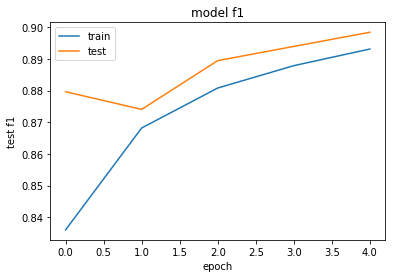

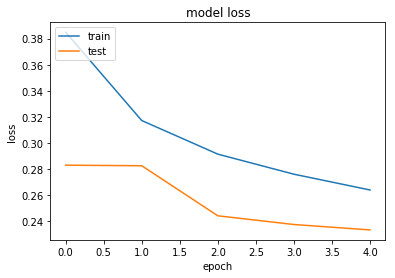

In [63]:
history = model.history

dict_keys(['val_loss', 'val_f1_m', 'loss', 'f1_m'])


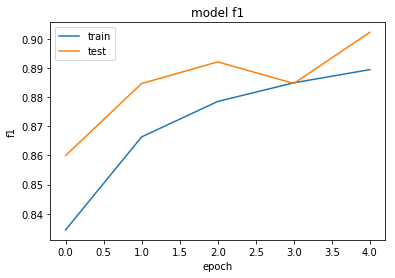

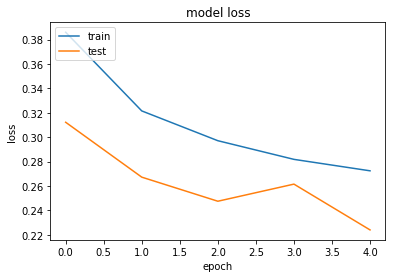

In [74]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


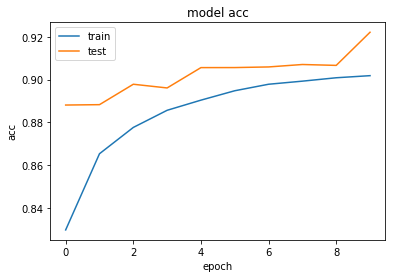

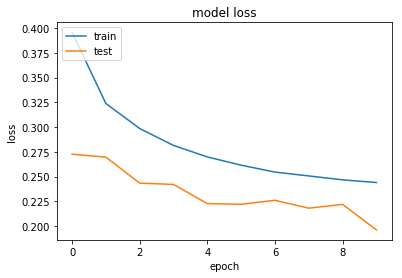

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


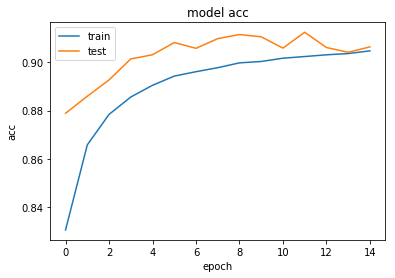

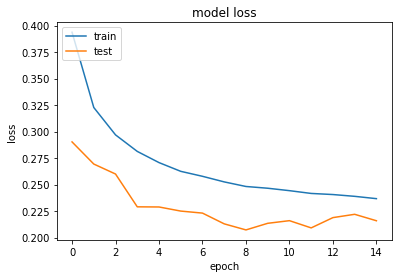

In [165]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
from keras.utils import plot_model
plot_model(model, to_file='segmentation/model.png', show_shapes=True, show_layer_names=False)

In [667]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [212]:
# without plains

weighted f1:  0.9237675645825536
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     46209
           1       0.17      0.78      0.27      1239

   micro avg       0.89      0.89      0.89     47448
   macro avg       0.58      0.84      0.61     47448
weighted avg       0.97      0.89      0.92     47448



In [161]:
predicted = model.predict([e_token_test, e_left_test, e_right_test, one_hot_test])  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)
print('weighted f1: ', f1_score(y, pr_classes, average='weighted'))
print('macro f1: ', f1_score(y, pr_classes, average='macro'))
print()
print(classification_report(y, pr_classes))

weighted f1:  0.9360752445171595
macro f1:  0.6872916450912361

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     48822
           1       0.30      0.68      0.42      2085

   micro avg       0.92      0.92      0.92     50907
   macro avg       0.64      0.81      0.69     50907
weighted avg       0.96      0.92      0.94     50907



In [166]:
predicted = model.predict([e_left_test, e_token_test, e_right_test, one_hot_test])  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)
print('weighted f1: ', f1_score(y, pr_classes, average='weighted'))
print('macro f1: ', f1_score(y, pr_classes, average='macro'))
print()
print(classification_report(y, pr_classes))

weighted f1:  0.9234121802764994
macro f1:  0.6459606691336544

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     48822
           1       0.24      0.61      0.34      2085

   micro avg       0.90      0.90      0.90     50907
   macro avg       0.61      0.77      0.65     50907
weighted avg       0.95      0.90      0.92     50907



In [122]:
type(annot['tokens'][0])

isanlp.annotation.Token

In [579]:
predicted = model.predict([e_left_test, e_token_test, e_right_test, one_hot_test], batch_size=120)  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)
print('weighted f1: ', f1_score(y, pr_classes, average='weighted'))
print(classification_report(y, pr_classes))

weighted f1:  0.9389925784266369
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     48822
           1       0.00      0.00      0.00      2085

   micro avg       0.96      0.96      0.96     50907
   macro avg       0.48      0.50      0.49     50907
weighted avg       0.92      0.96      0.94     50907



/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
predicted

array([[0.9956084 , 0.00439158],
       [0.9822108 , 0.01778916],
       [0.96172273, 0.03827727],
       ...,
       [0.98994386, 0.01005619],
       [0.10885904, 0.89114094],
       [0.00189316, 0.99810684]], dtype=float32)

In [93]:
pr_classes = np.argmax(predicted, axis=1)

In [94]:
pr_classes

array([0, 0, 0, ..., 0, 1, 1])

In [111]:
pr_classes[16]

1

In [113]:
pr_classes[20]

1

[16,
 20,
 36,
 42,
 46,
 51,
 56,
 64,
 79,
 88,
 114,
 118,
 124,
 140,
 144,
 150,
 156,
 160,
 167,
 169,
 170,
 187,
 191,
 201,
 218,
 227,
 238,
 258,
 266,
 274,
 297,
 303,
 305,
 314,
 319,
 329,
 337,
 345,
 350,
 354,
 371,
 378,
 384,
 401,
 405,
 426,
 434,
 452,
 463,
 468,
 482,
 492,
 501,
 506,
 510,
 518,
 532,
 548,
 559,
 568,
 569,
 574,
 582,
 590,
 596,
 604,
 608,
 624,
 626,
 639,
 642,
 646,
 655,
 659,
 670,
 685,
 696,
 704,
 709,
 719,
 723,
 739,
 747,
 758,
 775,
 776,
 785,
 790,
 792,
 798,
 799,
 814,
 817,
 828,
 841,
 852,
 866,
 868,
 876,
 884,
 890,
 900,
 906,
 921,
 924,
 939,
 957,
 962,
 985,
 1019,
 1028,
 1034,
 1042,
 1045,
 1053,
 1066,
 1075,
 1084,
 1086,
 1093,
 1098,
 1104,
 1123,
 1131,
 1152,
 1187,
 1197,
 1204,
 1209,
 1217,
 1225,
 1235,
 1240,
 1261,
 1272,
 1286,
 1290,
 1304,
 1305,
 1315,
 1318,
 1324,
 1333,
 1337,
 1351,
 1352,
 1354,
 1377,
 1385,
 1396,
 1408,
 1413,
 1415,
 1422,
 1441,
 1463,
 1471,
 1482,
 1494,
 1505,

In [90]:
def func(*args, **kwargs):
    another_func(*args)

In [91]:
def another_func(one, two, three, four):
    print(one)

In [92]:
func(1, 2, '3', 4)

1


In [80]:
func(1, 2, '3', 4)

<class 'tuple'>


In [103]:
def triplets_to_text(data):
    text = []
    for i, row in data.iterrows():
        text.append(row.token)
        if row['class']:
            text.append('\n')
    return ' '.join(text)

In [104]:
result = test

In [105]:
result['class'] = y

In [106]:
result['class'] = pr_classes

In [107]:
plain = triplets_to_text(result)

In [108]:
plain[:1000]

'африка в последний неделя не исчезать из фокус внимание мировой сми ( российский традиционно пренебрегать черный континент \n , а зря ) \n . сразу в четыре страна западный африка происходить событие , крайне важный для их будущий развитие \n , равно как и весь регион \n . начинать с нигерия \n , самый населенный африканский страна \n . численность ее гражданин уже \n перевалить за 150 миллион и продолжать стремительно расти \n . такой образ , она далеко обходить в план демографический потенциал , например , россия \n . уже из один этот факт следовать значение нигерия \n . кроме то , у она второй после юар ввп на континент , страна являться крупный производитель нефть и входить в число так называть Next Eleven \n , то быть государство \n , определенный банк « голдман сакс \n » как мочь входить в число ведущий экономика XXI век . ввп нигерия продолжать стремительно расти \n , несмотря на кризис \n . она выполнять роль региональный жандарм \n , посылать миротворческий контингент в либери

In [548]:
with open('temp.temp', 'w') as f:
    f.write(plain)

In [109]:
temp = ('\n').join([unit.strip() for unit in plain.split('\n')])

In [486]:
test.head(100).tail(50)

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
50,населенный,ADJ,acl,африканский,ADJ,amod,страна,NOUN,nmod,0,"[-0.6689053, -4.307198, -6.776492, -3.1433625,...","[-2.9349587, 3.2419572, 0.6698183, -0.46167374...","[1.4833744, -0.38067186, 1.6847211, 5.360056, ..."
51,африканский,ADJ,amod,страна,NOUN,nmod,.,,punct,1,"[-2.9349587, 3.2419572, 0.6698183, -0.46167374...","[1.4833744, -0.38067186, 1.6847211, 5.360056, ...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
52,страна,NOUN,nmod,.,,punct,численность,NOUN,nsubj,0,"[1.4833744, -0.38067186, 1.6847211, 5.360056, ...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-1.297001, 1.771469, -3.6366122, -2.472311, 0..."
53,.,,punct,численность,NOUN,nsubj,ее,PRON,det,0,"[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-1.297001, 1.771469, -3.6366122, -2.472311, 0...","[-3.7344062, -1.4247515, 1.9977547, -0.1507543..."
54,численность,NOUN,nsubj,ее,PRON,det,гражданин,NOUN,nmod,0,"[-1.297001, 1.771469, -3.6366122, -2.472311, 0...","[-3.7344062, -1.4247515, 1.9977547, -0.1507543...","[0.7914302, -2.018232, 1.1465118, -2.429168, -..."
55,ее,PRON,det,гражданин,NOUN,nmod,уже,ADV,advmod,0,"[-3.7344062, -1.4247515, 1.9977547, -0.1507543...","[0.7914302, -2.018232, 1.1465118, -2.429168, -...","[-0.28562543, -1.5532635, 0.63259214, 1.91457,..."
56,гражданин,NOUN,nmod,уже,ADV,advmod,перевалить,VERB,root,0,"[0.7914302, -2.018232, 1.1465118, -2.429168, -...","[-0.28562543, -1.5532635, 0.63259214, 1.91457,...","[-3.258799, -1.0222222, -0.28067988, -0.159341..."
57,уже,ADV,advmod,перевалить,VERB,root,за,ADP,case,0,"[-0.28562543, -1.5532635, 0.63259214, 1.91457,...","[-3.258799, -1.0222222, -0.28067988, -0.159341...","[-1.0206164, -2.3304315, 2.5210428, 0.8423993,..."
58,перевалить,VERB,root,за,ADP,case,150,,nummod:gov,0,"[-3.258799, -1.0222222, -0.28067988, -0.159341...","[-1.0206164, -2.3304315, 2.5210428, 0.8423993,...","[-2.0774262, -3.393422, -0.5944764, -4.234648,..."
59,за,ADP,case,150,,nummod:gov,миллион,NOUN,obl,1,"[-1.0206164, -2.3304315, 2.5210428, 0.8423993,...","[-2.0774262, -3.393422, -0.5944764, -4.234648,...","[-1.576582, 8.359062, -0.46447805, -8.815805, ..."


In [110]:
print(temp[1000:3000])

фур
. но проклятие страна , не давать она распрямляться во весь рост и становиться подлинный гигант континент
, помимо нефтяной проклятие
, являться ужасать политический нестабильность и межрелигиозный и межэтнический рознь
. через семь год после получение независимость нигерия скатиться в гражданский война , чуть не раскалывать страна
. последующий тридцать год ее единство удерживать череда диктатор
. в итог власть в рука гражданский находиться лишь одиннадцатый год
. в страна — много пятьсот язык , несколько сотня племя и народность , часто с давний история взаимный ненависть
. как следствие , весь возрастать число штат
; с три их число увеличиваться до 36
. нигерия раскалывать примерно пополам на мусульманский север и христианский юг , который весь пятьдесят год независимость все далеко уходить друг от друг
. достаточно сказать про ползучий процесс
введение шариат
, охватывать уже двенадцать штат и порождать множество проблема
. нельзя не упоминать о
клановость и присущий она вопиющ

In [562]:
print(temp[1000:3000])  # predicted

фур
. но проклятие страна , не давать она распрямляться во весь рост и становиться подлинный гигант континент
, помимо нефтяной проклятие
, являться ужасать политический нестабильность и межрелигиозный и межэтнический рознь
. через семь год после получение независимость нигерия скатиться в гражданский война
, чуть не раскалывать страна
. последующий тридцать год ее единство удерживать череда диктатор
. в итог власть в рука гражданский находиться лишь одиннадцатый год
. в страна — много пятьсот язык
, несколько сотня племя и народность , часто с давний история взаимный ненависть
. как следствие , весь возрастать число штат ; с три их число увеличиваться до 36
. нигерия раскалывать примерно пополам на мусульманский север и христианский юг
, который весь пятьдесят год независимость все далеко уходить друг от друг
. достаточно сказать про ползучий процесс
введение шариат
, охватывать уже двенадцать штат и порождать множество проблема . нельзя не упоминать о клановость и присущий она вопиющ

### Parse plain text 

In [551]:
sample = annot['text']

In [552]:
sample = pd.DataFrame(extract_triplets(annot['text'], annot), columns=['left_token', 'left_pos', 'left_link', 
                                            'token', 'pos', 'link', 
                                            'right_token', 'right_pos', 'right_link', 'class'])

In [553]:
sample

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class
0,,,,по,ADP,case,весь,PRON,det,0
1,по,ADP,case,весь,PRON,det,видимость,NOUN,obl,0
2,весь,PRON,det,видимость,NOUN,obl,",",,punct,0
3,видимость,NOUN,obl,",",,punct,протон,NOUN,appos,0
4,",",,punct,протон,NOUN,appos,-,,goeswith,0
5,протон,NOUN,appos,-,,goeswith,антипротонный,ADJ,goeswith,0
6,-,,goeswith,антипротонный,ADJ,goeswith,коллайдер,NOUN,appos,0
7,антипротонный,ADJ,goeswith,коллайдер,NOUN,appos,теватрон,NOUN,appos,0
8,коллайдер,NOUN,appos,теватрон,NOUN,appos,",",,punct,0
9,теватрон,NOUN,appos,",",,punct,располагать,VERB,acl,0


In [554]:
categ_feats

['left_pos', 'left_link', 'pos', 'link', 'right_pos', 'right_link']

In [555]:
one_hot_sample = vectorizer.transform(sample[categ_feats].to_dict(orient='records'))
print(one_hot_sample.shape)

(311, 146)


In [556]:
tag_for_embeddings = False

sample['e_left'] = sample.left_token.map(lambda row: get_embeddings(word2vec_model, row))
sample['e_token'] = sample.token.map(lambda row: get_embeddings(word2vec_model, row))
sample['e_right'] = sample.right_token.map(lambda row: get_embeddings(word2vec_model, row))

/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [615]:
embed_left = np.stack(sample['e_left'].values)
embed_lemma = np.stack(sample['e_token'].values)
embed_right = np.stack(sample['e_right'].values)

In [507]:
not_categ_columns = np.concatenate(tuple(sample.loc[:, e].values.reshape(-1, 1) for e in not_categ), axis =1)
plain_features = np.concatenate((one_hot_feats, not_categ_columns), axis = 1)
plain_features.shape

(311, 153)

In [557]:
one_hot_sample[:10]

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [614]:
sample['e_left'].values.to_array()

AttributeError: 'numpy.ndarray' object has no attribute 'to_array'

In [610]:
one_hot_sample.shape

(311, 146)

In [616]:
predicted = model.predict([embed_left, embed_lemma, embed_right, one_hot_sample], batch_size=120)  

In [ ]:
sample

In [640]:
sample['class'] = predicted

In [641]:
sample['class'].describe()

count    311.000000
mean       0.163736
std        0.261474
min        0.000003
25%        0.007316
50%        0.049874
75%        0.163901
max        0.999770
Name: class, dtype: float64

In [642]:
sample['class'] = sample['class'].map(lambda row: row > 0.7)

In [643]:
sample['class']

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8       True
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19      True
20      True
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
281    False
282    False
283    False
284    False
285    False
286    False
287    False
288    False
289    False
290    False
291    False
292    False
293     True
294    False
295    False
296    False
297    False
298    False
299    False
300    False
301    False
302    False
303    False
304    False
305    False
306    False
307    False
308    False
309     True
310     True
Name: class, Length: 311, dtype: bool

In [644]:
def triplets_to_text(data):
    text = []
    for i, row in data.iterrows():
        text.append(row.token)
        if row['class']:
            text.append('\n')
    return ' '.join(text)

In [645]:
plain = triplets_to_text(sample)

In [128]:
print(plain)

африка в последний неделя не исчезать из фокус внимание мировой сми ( российский традиционно пренебрегать черный континент 
 , а зря ) 
 . сразу в четыре страна западный африка происходить событие , крайне важный для их будущий развитие 
 , равно как и весь регион 
 . начинать с нигерия 
 , самый населенный африканский страна 
 . численность ее гражданин уже 
 перевалить за 150 миллион и продолжать стремительно расти 
 . такой образ , она далеко обходить в план демографический потенциал , например , россия 
 . уже из один этот факт следовать значение нигерия 
 . кроме то , у она второй после юар ввп на континент , страна являться крупный производитель нефть и входить в число так называть Next Eleven 
 , то быть государство 
 , определенный банк « голдман сакс 
 » как мочь входить в число ведущий экономика XXI век . ввп нигерия продолжать стремительно расти 
 , несмотря на кризис 
 . она выполнять роль региональный жандарм 
 , посылать миротворческий контингент в либерия 
 , сьерра - ле